<a href="https://colab.research.google.com/github/DamnScallion/Visionary-Unicorns-Project/blob/main/yolo/data-formatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Please run this file locally, not Google Colab

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import json

### Loading data. Convert it to YOLO Format and Architecture.

##### Annotation format: "category_id": 1, "bbox": [119, 25, 205, 606]

##### Yolo label format: 0 0.37277 0.54018 0.32589 0.95536

##### YOLO format data will be saved at 'yolo/data-yolo-format' folder

In [2]:
# Copy images to data-yolo-format folder
def yolo_dataset(src_dir, dest_dir):
  if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
  image_names = sorted(os.listdir(src_dir))
  for image_name in image_names:
    src_path = os.path.join(src_dir, image_name)
    dest_path = os.path.join(dest_dir, image_name)
    shutil.copyfile(src_path, dest_path)

In [3]:
# Convert annotations to yolo format label
def yolo_labels(images_dir, orig_labels_dir, yolo_labels_dir):
  with open(orig_labels_dir, 'r') as f:
    data = json.load(f)
    train_labels = pd.DataFrame(data)
    train_labels = train_labels[['image_id', 'category_id', 'bbox']]

  if not os.path.exists(yolo_labels_dir):
    os.makedirs(yolo_labels_dir)

  for _, row in train_labels.iterrows():
    image_id, category_id, bbox = row['image_id'], row['category_id'], row['bbox']
    category_id = int(category_id) - 1
    xmin, ymin, box_width, box_height = bbox
    xmin, ymin, box_width, box_height = int(xmin), int(ymin), int(box_width), int(box_height)
    xmax, ymax = (xmin + box_width, ymin + box_height)

    if str(image_id).isdigit():
      image_index = str(image_id).zfill(3)
      image_name = f"image_id_{image_index}.jpg"
    else:
      image_name = image_id

    curr_path = os.path.join(images_dir, image_name)
    image = cv2.imread(curr_path)
    image_width, image_height = image.shape[:2]

    x_center = (xmin + xmax) / (2 * image_width)
    y_center = (ymin + ymax) / (2 * image_height)
    box_width = box_width / image_width
    box_height = box_height / image_height

    yolo_label_format = f'{category_id} {x_center:.5f} {y_center:.5f} {box_width:.5f} {box_height:.5f}'

    label_file_name = str(image_name).replace('.jpg', '')

    label_path = os.path.join(yolo_labels_dir, label_file_name + '.txt')
    with open(label_path, 'w', encoding='utf8') as file:
      file.write(yolo_label_format)
      file.close()

### Convert original dataset

In [4]:
SRC_DIR = '../data/original'
DEST_DIR = '../yolo/data-yolo-format/original'

In [5]:
yolo_dataset(os.path.join(SRC_DIR, 'train'), os.path.join(DEST_DIR, 'images/train/'))

In [6]:
yolo_dataset(os.path.join(SRC_DIR, 'valid'), os.path.join(DEST_DIR, 'images/valid/'))

In [7]:
yolo_labels(os.path.join(SRC_DIR, 'train'), os.path.join(SRC_DIR, 'train_annotations'), os.path.join(DEST_DIR, 'labels/train/'))

In [8]:
yolo_labels(os.path.join(SRC_DIR, 'valid'), os.path.join(SRC_DIR, 'valid_annotations'), os.path.join(DEST_DIR, 'labels/valid/'))

### Convert 5k_augmented dataset

In [12]:
SRC_DIR2 = '../data/5k_augmented'
DEST_DIR2 = '../yolo/data-yolo-format/5k_augmented'

In [31]:
yolo_dataset(os.path.join(SRC_DIR2, '5k_train'), os.path.join(DEST_DIR2, 'images/train/'))

In [32]:
yolo_labels(os.path.join(SRC_DIR2, '5k_train'), os.path.join(SRC_DIR2, '5k_augmented_train_annotation.txt'), os.path.join(DEST_DIR2, 'labels/train/'))

### Testing the bbox save correctly or not

In [33]:
with open('../data/5k_augmented/5k_augmented_train_annotation.txt', 'r') as f:
    data = json.load(f)
    labels = pd.DataFrame(data)
    bboxes = labels[['image_id', 'bbox']]

79 -2 141 185


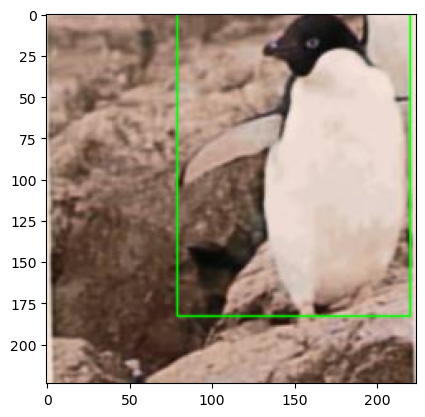

In [37]:
image_path = './data-yolo-format/5k_augmented/images/train/augmented_404.jpg'

image = cv2.imread(image_path)

left, top, width, height = bboxes.iloc[904]['bbox']
print(left, top, width, height)
start_point = (int(left), int(top))
end_point = (int(left)+int(width), int(top)+int(height))
color = (0, 255, 0)
thickness = 1
lineType = cv2.LINE_AA
cv2.rectangle(image, start_point, end_point, color, thickness, lineType)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))